<a href="https://colab.research.google.com/github/basukala/FIFA_20/blob/main/FIFA_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Basic Libraries

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from bokeh.io import output_notebook
from bokeh.io import show
from bokeh.plotting import figure
from bokeh.transform import cumsum
from bokeh.palettes import Spectral6
from bokeh.models import ColumnDataSource
from bokeh.layouts import gridplot

from scipy.stats import skew
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score,silhouette_samples


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Data

In [6]:
df = pd.read_csv("/content/drive/MyDrive/dataset/players_20.csv")

In [7]:
df.head()

sofifa_id                                         player_url  \
0     158023  https://sofifa.com/player/158023/lionel-messi/...   
1      20801  https://sofifa.com/player/20801/c-ronaldo-dos-...   
2     190871  https://sofifa.com/player/190871/neymar-da-sil...   
3     200389  https://sofifa.com/player/200389/jan-oblak/20/...   
4     183277  https://sofifa.com/player/183277/eden-hazard/2...   

          short_name                            long_name  age         dob  \
0           L. Messi       Lionel Andrés Messi Cuccittini   32  1987-06-24   
1  Cristiano Ronaldo  Cristiano Ronaldo dos Santos Aveiro   34  1985-02-05   
2          Neymar Jr        Neymar da Silva Santos Junior   27  1992-02-05   
3           J. Oblak                            Jan Oblak   26  1993-01-07   
4          E. Hazard                          Eden Hazard   28  1991-01-07   

   height_cm  weight_kg nationality                 club  ...   lwb   ldm  \
0        170         72   Argentina         FC Barcelona  ...  68+2  66+2   
1        187         83    Portugal             Juventus  ...  65+3  61+3   
2        175         68      Brazil  Paris Saint-Germain  ...  66+3  61+3   
3        188         87    Slovenia      Atlético Madrid  ...   NaN   NaN   
4        175         74     Belgium          Real Madrid  ...  66+3  63+3   

    cdm   rdm   rwb    lb   lcb    cb   rcb    rb  
0  66+2  66+2  68+2  63+2  52+2  52+2  52+2  63+2  
1  61+3  61+3  65+3  61+3  53+3  53+3  53+3  61+3  
2  61+3  61+3  66+3  61+3  46+3  46+3  46+3  61+3  
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4  63+3  63+3  66+3  61+3  49+3  49+3  49+3  61+3  

[5 rows x 104 columns]

In [8]:
df.shape

(18278, 104)

# Exploratory data analysis

In [9]:
output_notebook()

### Age

In [10]:
hist, edges = np.histogram(df['age'], density=True, bins = 20)
Age = figure(
    x_axis_label = 'Age of Players',
    title = 'Distribution of Age of Players'
)

Age.quad(
    bottom = 0,
    top = hist,
    left = edges[:-1],
    right = edges[1:],
    line_color = 'white'
)


show(Age)
#print("Skewness of age is", df['age'].skew())


In [11]:
print("The age of the youngest player is", df['age'].min())
print("The age of the oldest player is", df['age'].max())

The age of the youngest player is 16
The age of the oldest player is 42


### Height

In [12]:
hist, edges = np.histogram(df['height_cm'], density=True, bins = 20)
Height = figure(
    x_axis_label = 'Height of Players',
    title = 'Distribution of Height of Players',
)

Height.quad(
    bottom = 0,
    top = hist,
    left = edges[:-1],
    right = edges[1:],
    line_color = 'white'
)


show(Height)

### Weight

In [13]:
print("The weight of the lightest player is {} kg and his name is {}".format(df['weight_kg'].min(),
            list(df.loc[df['weight_kg'] == df['weight_kg'].min()]['short_name'])[0]))

print("The weight of the heaviest player is {} kg and his name is {}".format(df['weight_kg'].max(),
            list(df.loc[df['weight_kg'] == df['weight_kg'].max()]['short_name'])[0]))

The weight of the lightest player is 50 kg and his name is B. Al Mutairi
The weight of the heaviest player is 110 kg and his name is A. Akinfenwa


### Nationality

In [14]:
countries = list(df['nationality'].value_counts()[:40].index)
count = list(df['nationality'].value_counts()[:40].values)
source = ColumnDataSource(data = dict(Country = countries, counts = count, color = ['teal'] * 40))

p = figure(x_range = countries, plot_height = 600, plot_width = 1000, title = "Each Nationality Player Count", tools = "hover", tooltips = "@Country: @counts")
p.vbar(x = 'Country', top = 'counts', width = 0.9, source = source, color = 'color')

p.xgrid.grid_line_color = None
p.y_range.start = 0
p.xaxis.major_label_orientation = "vertical"
show(p)

### CLub

In [15]:
clubs = list(df['club'].value_counts()[:50].index)
count = list(df['club'].value_counts()[:50].values)
source = ColumnDataSource(data = dict(Clubs = clubs, count = count, color = ['lightskyblue'] * 50))

p3 = figure(x_range = clubs, plot_height = 400, plot_width = 1000, title = "Count of Players in Each Club", 
            tools = "hover", tooltips = "@Clubs: @count")

p3.vbar(x = 'Clubs', top = 'count', width = 0.9, source = source, color = 'color')

p3.xgrid.grid_line_color = None
p3.y_range.start = 0
p3.xaxis.major_label_orientation = "vertical"
show(p3)

### 50 teams have 33 players each

In [16]:
def avg_score(club_name):
    """
    A function which is used to return the average score of players belonging to club given as argument.
    """
    
    return np.mean(df.loc[df['club'] == club_name]['overall'])

clubs_40 = clubs[:40] # Taking the 20 country names(to which players belong) from the 'countries' variable defined above.
avg_scores_clubs = []

for i in clubs_40:
    avg_scores_clubs.append(round(avg_score(i), 2))
    
print(avg_scores_clubs)

[78.36, 71.94, 73.15, 70.79, 73.55, 71.76, 74.36, 73.27, 66.58, 75.42, 73.73, 72.03, 80.06, 71.85, 75.0, 72.3, 66.27, 72.97, 69.52, 73.33, 72.39, 69.18, 69.33, 68.88, 72.24, 71.3, 68.79, 69.79, 69.76, 69.73, 70.73, 70.33, 75.12, 69.97, 75.94, 72.58, 73.88, 77.06, 76.85, 76.48]


In [17]:
source = ColumnDataSource(data = dict(Clubs = clubs_40, Score = avg_scores_clubs, color = ['tomato'] * 40))

p4 = figure(x_range = clubs_40, plot_height = 400, plot_width = 1000, title = "Average Score of Players Belonging to Different Clubs ",
            tools = "hover", tooltips = "@Clubs: @Score")

p4.vbar(x = 'Clubs', top = 'Score', width = 0.9, source = source, color = 'color')

p4.xgrid.grid_line_color = None
p4.y_range.start = 0

p4.xaxis.major_label_orientation = "vertical"

show(p4)


In [18]:
print("The average overall score of all players is ", round(np.mean(df['overall']), 2))

The average overall score of all players is  66.24


### Overall

In [19]:
print("The heighest rated player is {} and his rating is {}".format(df.loc[df['overall'] == 
                                                                                 df['overall'].max()]['short_name'][0],
                                                                    df.loc[df['overall'] == 
                                                                                 df['overall'].max()]['overall'][0]))
df.loc[df['overall'] == df['overall'].min()][['short_name', 'overall', 'nationality']]

The heighest rated player is L. Messi and his rating is 94


short_name  overall          nationality
18235       Tao Qianglong       48             China PR
18236        B. McPherson       48              England
18237             J. Hope       48              England
18238            L. Singh       48               Canada
18239          V. Storsve       48               Norway
18240          C. Painter       48              England
18241             M. Peck       48              England
18242          R. Wikberg       48               Sweden
18243        E. Sartorius       48              England
18244           K. Barker       48              England
18245         C. Pattison       48              England
18246        H. Kyprianou       48               Cyprus
18247           Liu Guobo       48             China PR
18248          T. Klysner       48              Denmark
18249       Shan Huanhuan       48             China PR
18250           R. Roache       48  Republic of Ireland
18251  G. Sykes-Kenworthy       48              England
18252         A. Aksungur       48               Turkey
18253           N. Morley       48              England
18254     E. Jääskeläinen       48              Finland
18255            C. Heath       48              England
18256       S. Cartwright       48              England
18257        Song Min Kyu       48       Korea Republic
18258          L. Collins       48                Wales
18259          H. Sveijer       48               Sweden
18260       A. De Angelis       48                Italy
18261           H. Shirai       48                Japan
18262           S. Callan       48  Republic of Ireland
18263          F. Nevarez       48               Mexico
18264        Zhang Yufeng       48             China PR
18265           L. Offord       48              England
18266           Wang Peng       48             China PR
18267             J. Ryan       48  Republic of Ireland
18268        M. Gallagher       48  Republic of Ireland
18269        Huang Jiahui       48             China PR
18270            M. Sagaf       48              England
18271            E. Tweed       48  Republic of Ireland
18272           P. Martin       48  Republic of Ireland
18273          Shao Shuai       48             China PR
18274        Xiao Mingjie       48             China PR
18275           Zhang Wei       48             China PR
18276        Wang Haijian       48             China PR
18277          Pan Ximing       48             China PR

### Potential

In [20]:
df.loc[df['potential'] == df['potential'].max()]
#K. Mbappe has a potential score of 95 which is amazing, he truely deserves it

sofifa_id                                         player_url short_name  \
10     231747  https://sofifa.com/player/231747/kylian-mbappe...  K. Mbappé   

        long_name  age         dob  height_cm  weight_kg nationality  \
10  Kylian Mbappé   20  1998-12-20        178         73      France   

                   club  ...   lwb   ldm   cdm   rdm   rwb    lb   lcb    cb  \
10  Paris Saint-Germain  ...  66+3  62+3  62+3  62+3  66+3  63+3  54+3  54+3   

     rcb    rb  
10  54+3  63+3  

[1 rows x 104 columns]

In [21]:
df.loc[df['potential'] == df['potential'].min()]

sofifa_id                                         player_url  \
18233     182461  https://sofifa.com/player/182461/ting-zhou/20/...   
18234     247775  https://sofifa.com/player/247775/junzhe-zhang/...   

         short_name long_name  age         dob  height_cm  weight_kg  \
18233     Zhou Ting        周挺   40  1979-02-05        182         73   
18234  Zhang Junzhe       张俊哲   28  1991-02-20        183         69   

      nationality                    club  ...   lwb   ldm   cdm   rdm   rwb  \
18233    China PR        Dalian YiFang FC  ...  48+2  50+2  50+2  50+2  48+2   
18234    China PR  Hebei China Fortune FC  ...  47+2  42+2  42+2  42+2  47+2   

         lb   lcb    cb   rcb    rb  
18233  48+2  51+2  51+2  51+2  48+2  
18234  48+2  46+2  46+2  46+2  48+2  

[2 rows x 104 columns]

### Foot

In [22]:
from math import pi
foot = df['preferred_foot'].value_counts().index.to_list()
count = df['preferred_foot'].value_counts().values
count1 = count / sum(count) * 100
angle = count / sum(count) * 2 * pi

source = ColumnDataSource(data = dict(foot = foot, count = count, color = ['skyblue', 'salmon'], angle = angle, percentage = count1))

p6 = figure(x_range = foot, plot_height = 300, plot_width = 500, title = "Count of left and right foot players ",
                tools = "hover", tooltips = "@foot: @count")

p6.vbar(x = 'foot', top = 'count', width = 0.9, source = source, color = 'color')

p6.xgrid.grid_line_color = None
p6.y_range.start = 0

p6.xaxis.major_label_orientation = "horizontal"

p7 = figure(plot_height = 300, plot_width = 300, title="Pie Chart",
           tools = "hover", tooltips = "@foot: @percentage", x_range=(-0.5, 1.0))  ## Pie chart for right and left foot players

p7.wedge(x = 0, y = 1, radius = 0.4,
        start_angle = cumsum('angle', include_zero=True), end_angle = cumsum('angle'),
        line_color = "white", fill_color = 'color', legend_field = 'foot', source = source)
p7.legend.location = "top_right"
p7.legend.label_text_font_size = '5pt'

show(gridplot([[p7, p6]]))

In [23]:
#There are more right foot players as compared to left players
print("The average of overall scores of players who prefer Right foot is", round(df.loc[df['preferred_foot'] == 'Right']['overall'].mean(), 2))

print("The average of overall scores of players who prefer Left foot is", round(df.loc[df['preferred_foot'] == 'Left']['overall'].mean(), 2))

The average of overall scores of players who prefer Right foot is 66.11
The average of overall scores of players who prefer Left foot is 66.68


### WorkRate

In [24]:
different_work_rates = df['work_rate'].value_counts().keys().to_list()
count = df['work_rate'].value_counts().values
count1 = count / sum(count) * 100
angle = count / sum(count) * 2 * pi

source = ColumnDataSource(data = dict(work_rates = different_work_rates, count = count, color = ['skyblue', 'salmon', 'turquoise', 'cyan', 'red', 'lightseagreen', 'teal', 'mediumaquamarine', 'yellowgreen'], angle = angle, percentage = count1))


p12 = figure(plot_height = 600, plot_width = 600, title="Pie Chart",
           tools = "hover", tooltips = "@work_rates: @percentage", x_range=(-1.0, 1.0))  ## Pie chart for work rates

p12.wedge(x = 0, y = 1, radius = 0.8,
        start_angle = cumsum('angle', include_zero=True), end_angle = cumsum('angle'),
        line_color = "white", fill_color = 'color', legend_field = 'work_rates', source = source)

p12.legend.location = "top_right"

p12.legend.label_text_font_size = '5pt'

show(p12)

In [25]:
df.loc[df['work_rate'] == 'High/High'].head(5)

sofifa_id                                         player_url  \
5      192985  https://sofifa.com/player/192985/kevin-de-bruy...   
8      177003  https://sofifa.com/player/177003/luka-modric/2...   
12     202126  https://sofifa.com/player/202126/harry-kane/20...   
22     194765  https://sofifa.com/player/194765/antoine-griez...   
27     190460  https://sofifa.com/player/190460/christian-eri...   

      short_name                     long_name  age         dob  height_cm  \
5   K. De Bruyne               Kevin De Bruyne   28  1991-06-28        181   
8      L. Modrić                   Luka Modrić   33  1985-09-09        172   
12       H. Kane                    Harry Kane   25  1993-07-28        188   
22  A. Griezmann             Antoine Griezmann   28  1991-03-21        176   
27    C. Eriksen  Christian  Dannemann Eriksen   27  1992-02-14        181   

    weight_kg nationality               club  ...   lwb   ldm   cdm   rdm  \
5          70     Belgium    Manchester City  ...  77+3  77+3  77+3  77+3   
8          66     Croatia        Real Madrid  ...  81+3  81+3  81+3  81+3   
12         89     England  Tottenham Hotspur  ...  65+3  66+3  66+3  66+3   
22         73      France       FC Barcelona  ...  73+3  71+3  71+3  71+3   
27         76     Denmark  Tottenham Hotspur  ...  71+3  71+3  71+3  71+3   

     rwb    lb   lcb    cb   rcb    rb  
5   77+3  73+3  66+3  66+3  66+3  73+3  
8   81+3  79+3  72+3  72+3  72+3  79+3  
12  65+3  62+3  60+3  60+3  60+3  62+3  
22  73+3  70+3  65+3  65+3  65+3  70+3  
27  71+3  66+3  57+3  57+3  57+3  66+3  

[5 rows x 104 columns]

### Extracting Categorical and Numerical Columns

In [26]:
df_categorical = df.select_dtypes(include=['object']).copy()
df_categorical.head()

player_url         short_name  \
0  https://sofifa.com/player/158023/lionel-messi/...           L. Messi   
1  https://sofifa.com/player/20801/c-ronaldo-dos-...  Cristiano Ronaldo   
2  https://sofifa.com/player/190871/neymar-da-sil...          Neymar Jr   
3  https://sofifa.com/player/200389/jan-oblak/20/...           J. Oblak   
4  https://sofifa.com/player/183277/eden-hazard/2...          E. Hazard   

                             long_name         dob nationality  \
0       Lionel Andrés Messi Cuccittini  1987-06-24   Argentina   
1  Cristiano Ronaldo dos Santos Aveiro  1985-02-05    Portugal   
2        Neymar da Silva Santos Junior  1992-02-05      Brazil   
3                            Jan Oblak  1993-01-07    Slovenia   
4                          Eden Hazard  1991-01-07     Belgium   

                  club player_positions preferred_foot      work_rate  \
0         FC Barcelona       RW, CF, ST           Left     Medium/Low   
1             Juventus           ST, LW          Right       High/Low   
2  Paris Saint-Germain          LW, CAM          Right    High/Medium   
3      Atlético Madrid               GK          Right  Medium/Medium   
4          Real Madrid           LW, CF          Right    High/Medium   

    body_type  ...   lwb   ldm   cdm   rdm   rwb    lb   lcb    cb   rcb    rb  
0       Messi  ...  68+2  66+2  66+2  66+2  68+2  63+2  52+2  52+2  52+2  63+2  
1  C. Ronaldo  ...  65+3  61+3  61+3  61+3  65+3  61+3  53+3  53+3  53+3  61+3  
2      Neymar  ...  66+3  61+3  61+3  61+3  66+3  61+3  46+3  46+3  46+3  61+3  
3      Normal  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4      Normal  ...  66+3  63+3  63+3  63+3  66+3  61+3  49+3  49+3  49+3  61+3  

[5 rows x 43 columns]

In [27]:
df_numerical = df.select_dtypes(exclude=['object']).copy()
df_numerical.head()

sofifa_id  age  height_cm  weight_kg  overall  potential  value_eur  \
0     158023   32        170         72       94         94   95500000   
1      20801   34        187         83       93         93   58500000   
2     190871   27        175         68       92         92  105500000   
3     200389   26        188         87       91         93   77500000   
4     183277   28        175         74       91         91   90000000   

   wage_eur  international_reputation  weak_foot  ...  mentality_penalties  \
0    565000                         5          4  ...                   75   
1    405000                         5          4  ...                   85   
2    290000                         5          5  ...                   90   
3    125000                         3          3  ...                   11   
4    470000                         4          4  ...                   88   

   mentality_composure  defending_marking  defending_standing_tackle  \
0                   96                 33                         37   
1                   95                 28                         32   
2                   94                 27                         26   
3                   68                 27                         12   
4                   91                 34                         27   

   defending_sliding_tackle  goalkeeping_diving  goalkeeping_handling  \
0                        26                   6                    11   
1                        24                   7                    11   
2                        29                   9                     9   
3                        18                  87                    92   
4                        22                  11                    12   

   goalkeeping_kicking  goalkeeping_positioning  goalkeeping_reflexes  
0                   15                       14                     8  
1                   15                       14                    11  
2                   15                       15                    11  
3                   78                       90                    89  
4                    6                        8                     8  

[5 rows x 61 columns]

In [28]:
df_numerical.shape

(18278, 61)

### Analysis For Numerical Features

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


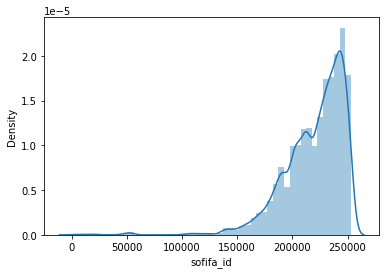

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


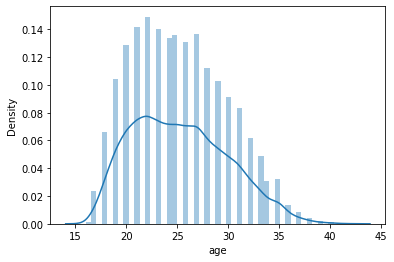

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


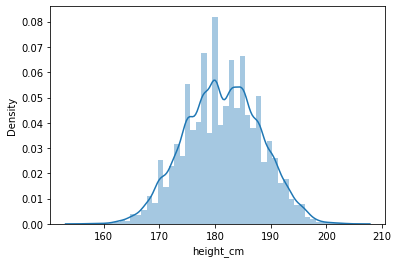

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


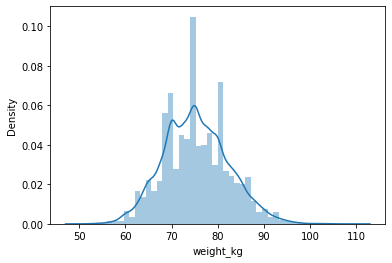

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


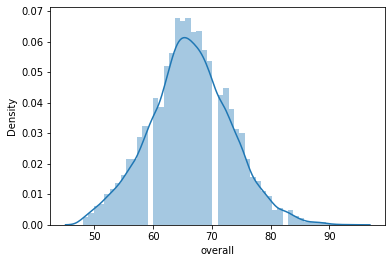

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


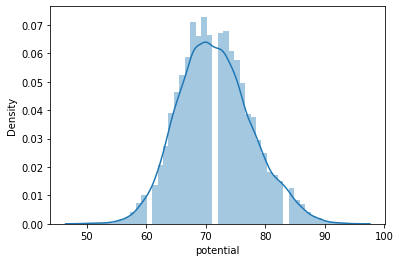

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


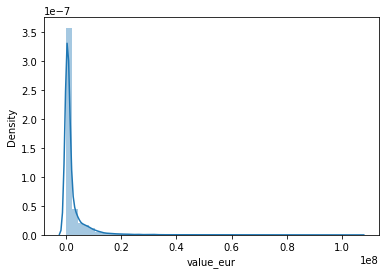

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


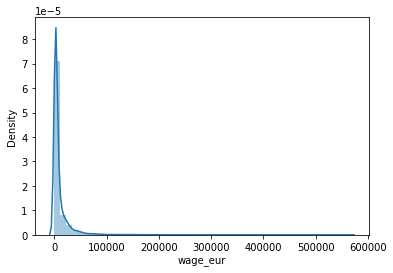

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


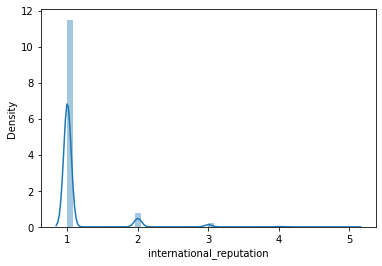

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


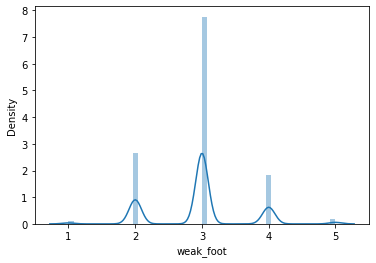

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


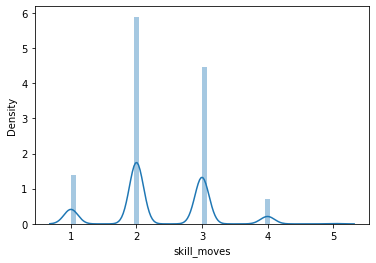

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


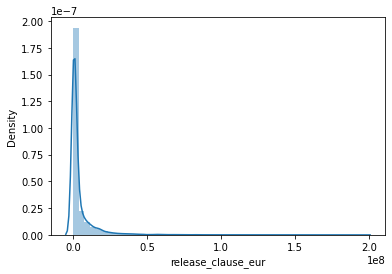

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


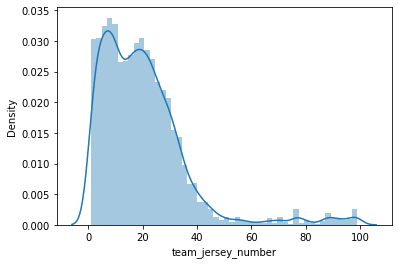

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


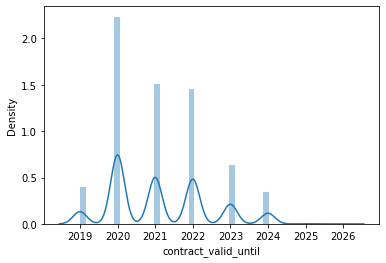

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


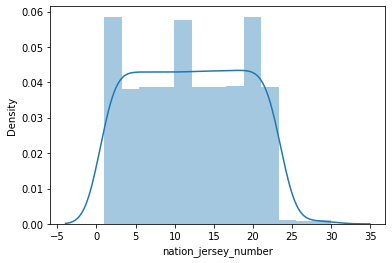

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


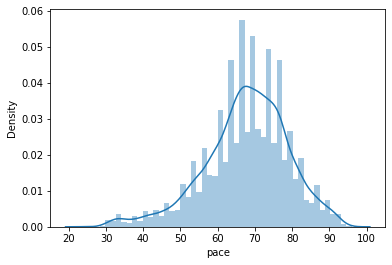

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


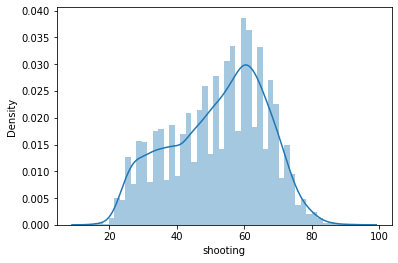

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


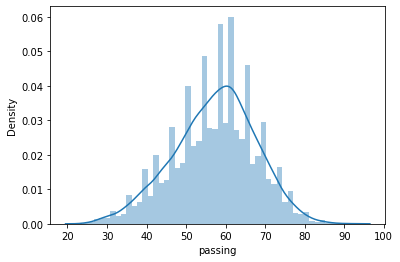

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


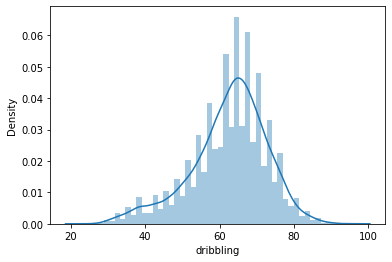

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


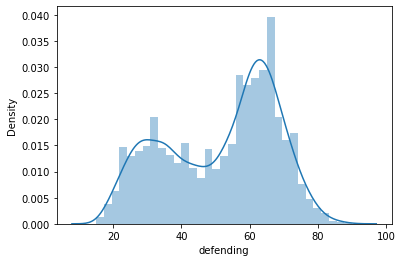

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


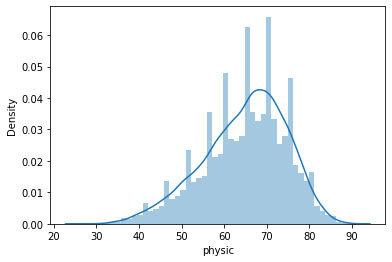

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


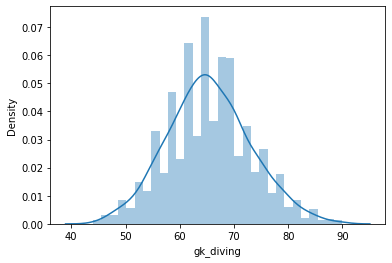

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


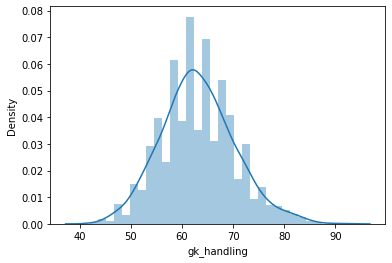

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


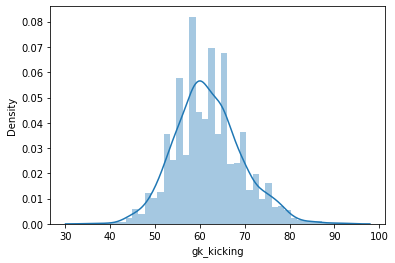

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


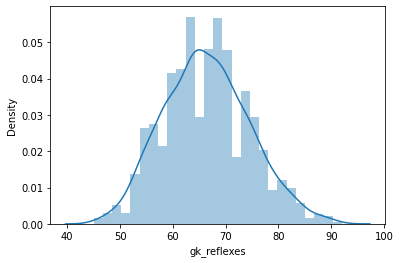

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


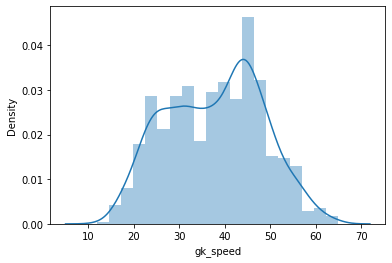

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


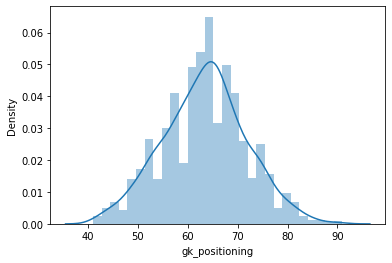

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


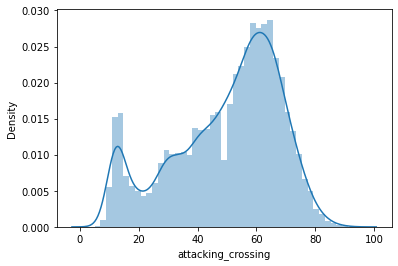

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


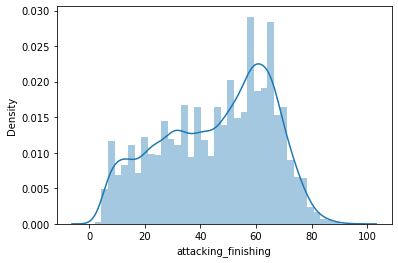

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


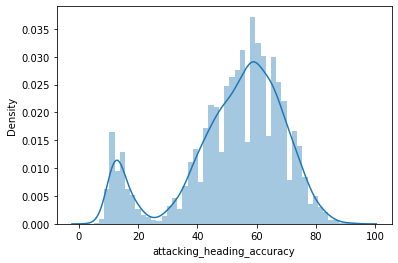

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


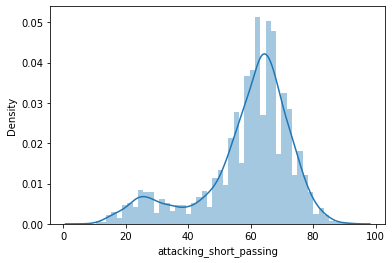

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


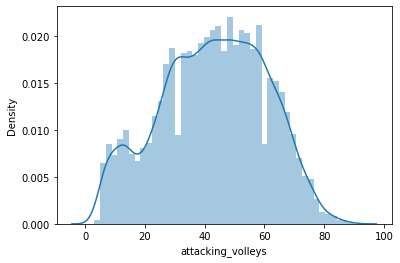

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


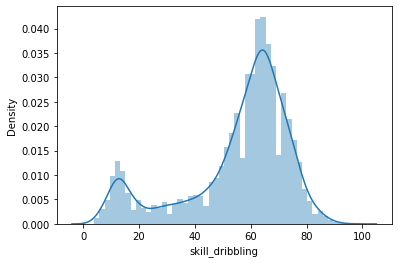

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


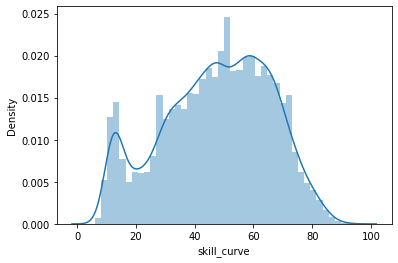

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


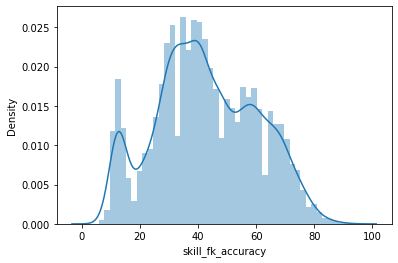

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


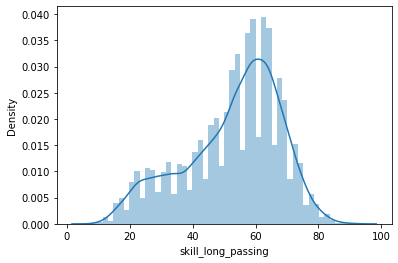

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


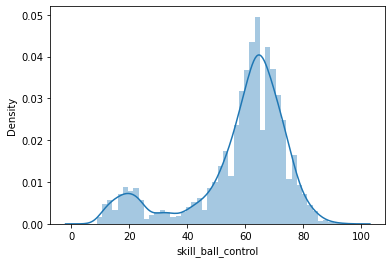

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


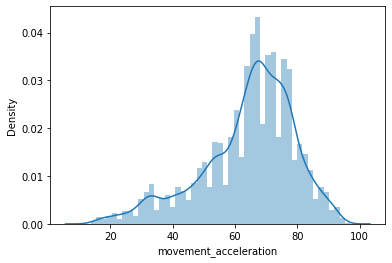

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


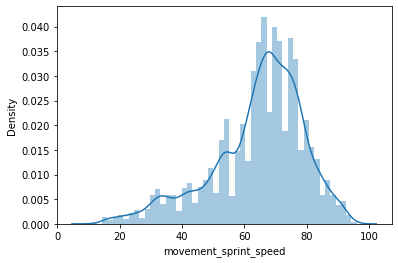

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


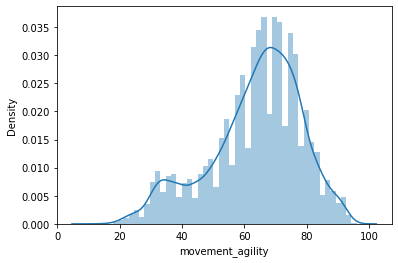

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


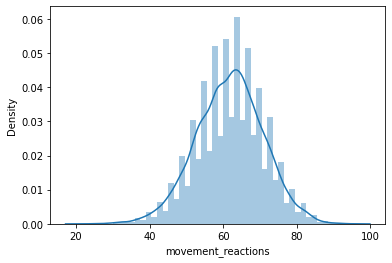

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


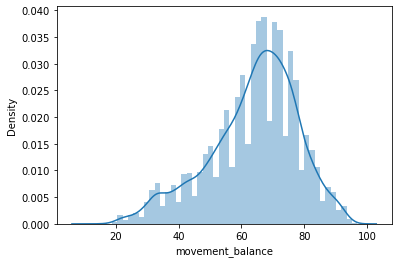

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


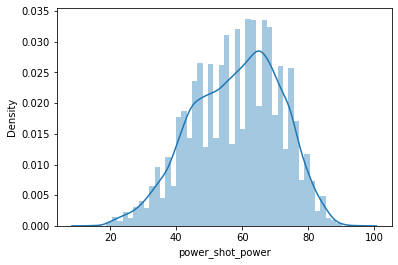

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


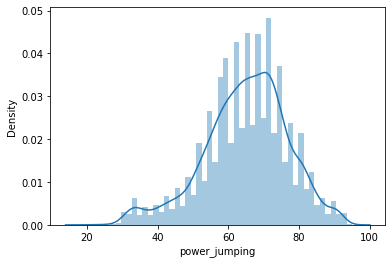

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


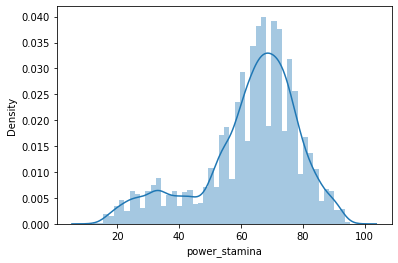

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


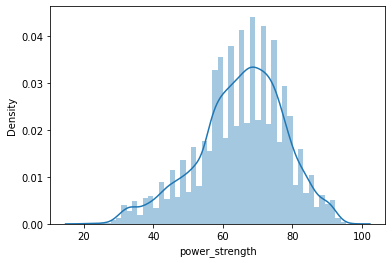

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


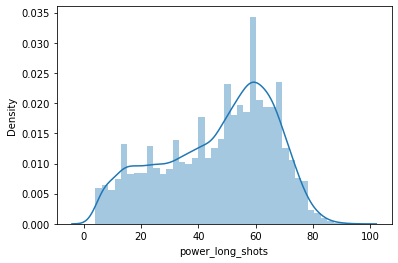

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


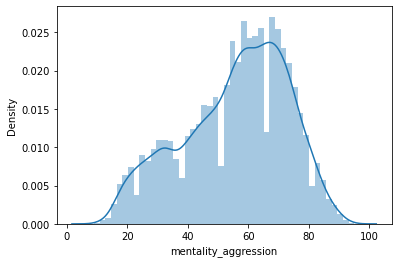

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


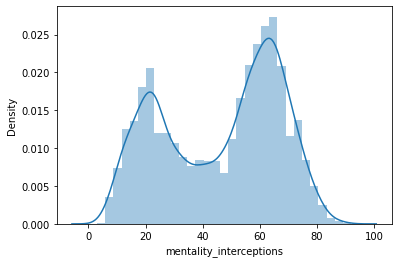

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


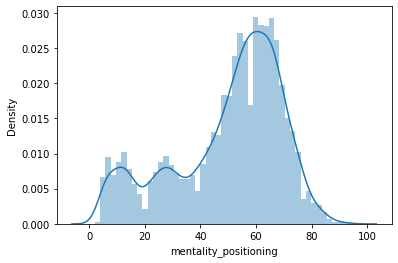

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


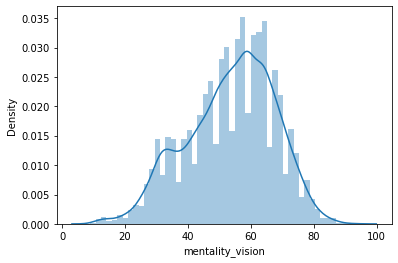

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


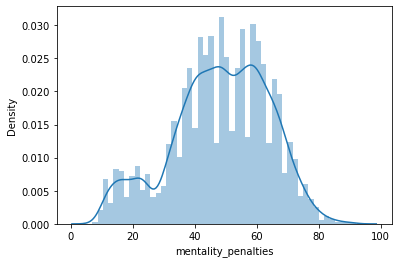

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


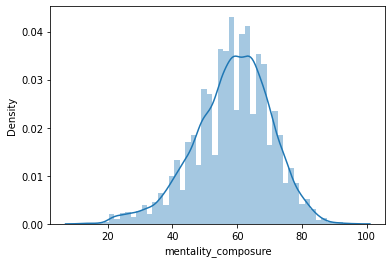

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


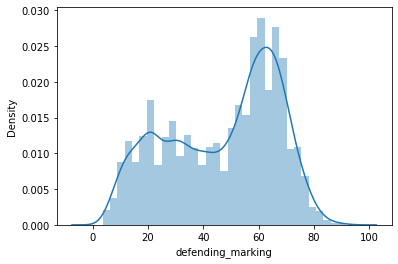

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


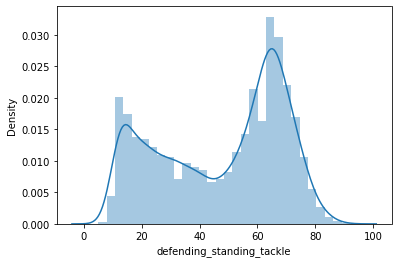

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


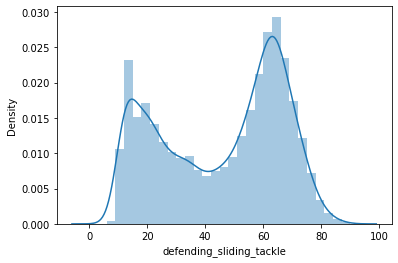

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


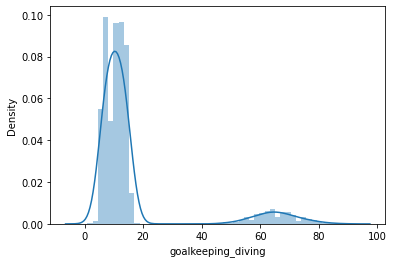

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


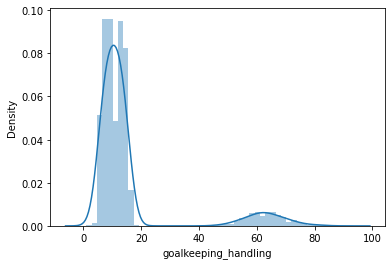

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


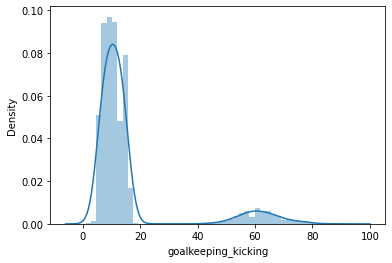

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


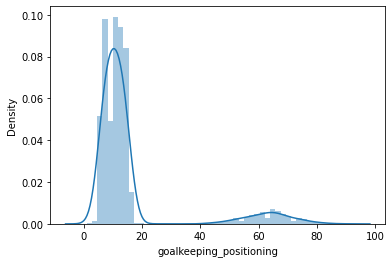

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


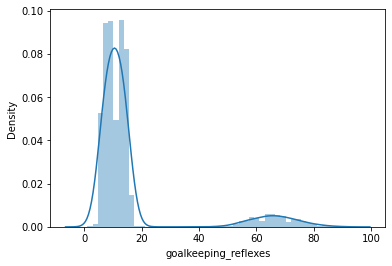

In [29]:
for i,k in df_numerical.iteritems():
    #print(df_numerical[i])
    sns.distplot(df_numerical[i].dropna(axis=0))
    plt.show()
   

In [30]:
df_numerical['BMI'] = df_numerical ['weight_kg'] / (df_numerical['height_cm'] / 100) ** 2

In [31]:
df_numerical.drop(['weight_kg','height_cm'],axis=1,inplace=True)

In [32]:
df_numerical.shape

(18278, 60)

In [33]:
df.isnull().sum()

sofifa_id        0
player_url       0
short_name       0
long_name        0
age              0
              ... 
lb            2036
lcb           2036
cb            2036
rcb           2036
rb            2036
Length: 104, dtype: int64

## Checking null values ,filling with mean and mode and drop the unused features

In [34]:
def fill_missingVal(data,limit):
    obj = data.isnull().sum()
    for key,value in obj.iteritems():
        
        if (value>0):
            if(value<limit):
                #print(df_categorical[key].mode())
                if(data[key].dtypes=='object'):
                    data[key] = data[key].fillna(data[key].mode()[0])
                else:
                    data[key] = data[key].fillna(data[key].mean())
            else:
                data.drop([key],axis=1,inplace=True)

In [35]:
#fill up nan value with mode for Categorical data
fill_missingVal(df_categorical,9000)

In [36]:
#fill up nan value with mode for Categorical data
fill_missingVal(df_numerical,9000)

In [37]:
print(df_numerical.shape)
print(df_categorical.shape)

(18278, 53)
(18278, 39)


### Removing Unnecessary Numerical Features

In [38]:
#There is still unnecessary features so remove those feature
unused_item=['sofifa_id','team_jersey_number']
df_numerical = df_numerical.drop(unused_item, axis = 1)

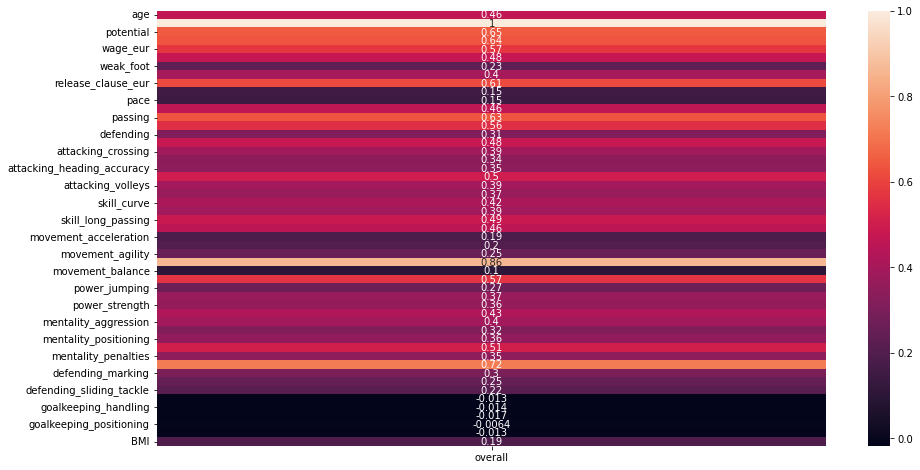

In [39]:
corr = df_numerical.corr()
corr = corr.filter(items = ['overall'])
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True)

### Listing some numerical columns by analysing heatmap and checking skewness value

In [40]:
skew_values = skew(df_numerical)
pd.concat([pd.DataFrame(list(df_numerical), columns=['Features']), 
           pd.DataFrame(list(skew_values), columns=['Skewness degree'])], axis = 1)

Features  Skewness degree
0                          age         0.380589
1                      overall         0.070888
2                    potential         0.249920
3                    value_eur         6.425414
4                     wage_eur         7.820454
5     international_reputation         4.296162
6                    weak_foot         0.162972
7                  skill_moves         0.173626
8           release_clause_eur         6.702722
9         contract_valid_until         0.508746
10                        pace        -0.580845
11                    shooting        -0.309211
12                     passing        -0.252771
13                   dribbling        -0.644908
14                   defending        -0.363277
15                      physic        -0.514910
16          attacking_crossing        -0.604794
17         attacking_finishing        -0.316910
18  attacking_heading_accuracy        -0.880861
19     attacking_short_passing        -1.136120
20           attacking_volleys        -0.156454
21             skill_dribbling        -1.117501
22                 skill_curve        -0.263078
23           skill_fk_accuracy         0.094109
24          skill_long_passing        -0.590322
25          skill_ball_control        -1.290189
26       movement_acceleration        -0.811382
27       movement_sprint_speed        -0.848862
28            movement_agility        -0.634461
29          movement_reactions        -0.134737
30            movement_balance        -0.591537
31            power_shot_power        -0.270889
32               power_jumping        -0.450762
33               power_stamina        -0.886934
34              power_strength        -0.443998
35            power_long_shots        -0.428309
36        mentality_aggression        -0.425081
37     mentality_interceptions        -0.266080
38       mentality_positioning        -0.750408
39            mentality_vision        -0.358366
40         mentality_penalties        -0.359724
41         mentality_composure        -0.463850
42           defending_marking        -0.346033
43   defending_standing_tackle        -0.342559
44    defending_sliding_tackle        -0.274135
45          goalkeeping_diving         2.442775
46        goalkeeping_handling         2.429336
47         goalkeeping_kicking         2.432650
48     goalkeeping_positioning         2.460464
49        goalkeeping_reflexes         2.455286
50                         BMI         0.114714

In [41]:
skewed_feature=['international_reputation','release_clause_eur','goalkeeping_diving','goalkeeping_handling','goalkeeping_kicking','goalkeeping_positioning','goalkeeping_reflexes']
for col in skewed_feature:
    df_numerical[col]=np.log(df_numerical[col])

In [42]:
df_new=pd.concat([df_numerical.reset_index(drop=True),pd.DataFrame(df_categorical['short_name'])],axis=1)
df_new.head()

age  overall  potential  value_eur  wage_eur  international_reputation  \
0   32       94         94   95500000    565000                  1.609438   
1   34       93         93   58500000    405000                  1.609438   
2   27       92         92  105500000    290000                  1.609438   
3   26       91         93   77500000    125000                  1.098612   
4   28       91         91   90000000    470000                  1.386294   

   weak_foot  skill_moves  release_clause_eur  contract_valid_until  ...  \
0          4            4           19.092604                2021.0  ...   
1          4            5           18.385054                2022.0  ...   
2          5            5           19.089535                2022.0  ...   
3          3            1           18.919636                2023.0  ...   
4          4            4           19.033160                2024.0  ...   

   defending_marking  defending_standing_tackle  defending_sliding_tackle  \
0                 33                         37                        26   
1                 28                         32                        24   
2                 27                         26                        29   
3                 27                         12                        18   
4                 34                         27                        22   

   goalkeeping_diving  goalkeeping_handling  goalkeeping_kicking  \
0            1.791759              2.397895             2.708050   
1            1.945910              2.397895             2.708050   
2            2.197225              2.197225             2.708050   
3            4.465908              4.521789             4.356709   
4            2.397895              2.484907             1.791759   

   goalkeeping_positioning  goalkeeping_reflexes        BMI         short_name  
0                 2.639057              2.079442  24.913495           L. Messi  
1                 2.639057              2.397895  23.735308  Cristiano Ronaldo  
2                 2.708050              2.397895  22.204082          Neymar Jr  
3                 4.499810              4.488636  24.615211           J. Oblak  
4                 2.079442              2.079442  24.163265          E. Hazard  

[5 rows x 52 columns]

In [43]:
df_edited = df_new[df_new.overall > 60] # extracting players with overall above 60
df_edited.head()

age  overall  potential  value_eur  wage_eur  international_reputation  \
0   32       94         94   95500000    565000                  1.609438   
1   34       93         93   58500000    405000                  1.609438   
2   27       92         92  105500000    290000                  1.609438   
3   26       91         93   77500000    125000                  1.098612   
4   28       91         91   90000000    470000                  1.386294   

   weak_foot  skill_moves  release_clause_eur  contract_valid_until  ...  \
0          4            4           19.092604                2021.0  ...   
1          4            5           18.385054                2022.0  ...   
2          5            5           19.089535                2022.0  ...   
3          3            1           18.919636                2023.0  ...   
4          4            4           19.033160                2024.0  ...   

   defending_marking  defending_standing_tackle  defending_sliding_tackle  \
0                 33                         37                        26   
1                 28                         32                        24   
2                 27                         26                        29   
3                 27                         12                        18   
4                 34                         27                        22   

   goalkeeping_diving  goalkeeping_handling  goalkeeping_kicking  \
0            1.791759              2.397895             2.708050   
1            1.945910              2.397895             2.708050   
2            2.197225              2.197225             2.708050   
3            4.465908              4.521789             4.356709   
4            2.397895              2.484907             1.791759   

   goalkeeping_positioning  goalkeeping_reflexes        BMI         short_name  
0                 2.639057              2.079442  24.913495           L. Messi  
1                 2.639057              2.397895  23.735308  Cristiano Ronaldo  
2                 2.708050              2.397895  22.204082          Neymar Jr  
3                 4.499810              4.488636  24.615211           J. Oblak  
4                 2.079442              2.079442  24.163265          E. Hazard  

[5 rows x 52 columns]

In [44]:
names = df_edited.short_name.tolist() # saving names for later

In [45]:
data = df_edited.drop('short_name', axis = 1)

In [46]:
data.shape

(14626, 51)

### Removing Unneccesary Features from Categorical Features

In [47]:
#There is still unnecessary features so remove those feature
unused_cat_item=['player_url','long_name','dob','joined','body_type','real_face']
df_categorical = df_categorical.drop(unused_cat_item, axis = 1)

### Only 51 Numerical Feature has been selected after the EDA part.

In [48]:
from sklearn import preprocessing

x = data.values # numpy array
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)
X_norm = pd.DataFrame(x_scaled)

In [49]:
data.shape

(14626, 51)

## Standarized Data Using PCA

In [50]:
pca = PCA() # 2D PCA for the plot
pca.fit(X_norm)

PCA()

In [51]:
pca.explained_variance_ #variance of each feature

array([6.26605941e-01, 3.20950932e-01, 1.11678265e-01, 8.37985311e-02,
       6.07739383e-02, 4.27871448e-02, 2.91505643e-02, 2.45820912e-02,
       2.29084428e-02, 1.80531937e-02, 1.46454308e-02, 1.29170577e-02,
       1.23436535e-02, 1.09923584e-02, 1.01260270e-02, 9.14077521e-03,
       9.08400300e-03, 7.51846191e-03, 6.99636515e-03, 6.45646368e-03,
       5.94940262e-03, 5.50854868e-03, 5.39014813e-03, 5.10609133e-03,
       4.90674263e-03, 4.61026153e-03, 4.55147071e-03, 4.25815861e-03,
       4.15544027e-03, 4.03221339e-03, 3.97030081e-03, 3.91106436e-03,
       3.88207304e-03, 3.80479800e-03, 3.44777826e-03, 3.26196171e-03,
       3.15009993e-03, 2.85226185e-03, 2.63534701e-03, 2.07311532e-03,
       1.91963694e-03, 1.74091455e-03, 1.42005220e-03, 1.12430841e-03,
       8.30641507e-04, 6.71425770e-04, 5.30969758e-04, 3.00355230e-04,
       2.22494165e-04, 8.66946964e-05, 5.47349584e-05])

In [52]:
pca.explained_variance_ratio_ #variance ratio of each feature
#if we sum up all the value that would be equals to 1
#9.82044672e-01 denotes 0.98 , 1.61764899e-02 denotes 0.016

array([4.09046649e-01, 2.09515893e-01, 7.29032670e-02, 5.47034524e-02,
       3.96730611e-02, 2.79313314e-02, 1.90294089e-02, 1.60471220e-02,
       1.49545690e-02, 1.17850756e-02, 9.56049724e-03, 8.43221999e-03,
       8.05790336e-03, 7.17578160e-03, 6.61024278e-03, 5.96707311e-03,
       5.93001237e-03, 4.90803142e-03, 4.56720808e-03, 4.21476187e-03,
       3.88375380e-03, 3.59596555e-03, 3.51867399e-03, 3.33324249e-03,
       3.20310820e-03, 3.00956615e-03, 2.97118766e-03, 2.77971432e-03,
       2.71266007e-03, 2.63221790e-03, 2.59180154e-03, 2.55313214e-03,
       2.53420669e-03, 2.48376175e-03, 2.25070024e-03, 2.12939970e-03,
       2.05637664e-03, 1.86194875e-03, 1.72034734e-03, 1.35332402e-03,
       1.25313376e-03, 1.13646427e-03, 9.27006203e-04, 7.33945464e-04,
       5.42240510e-04, 4.38304910e-04, 3.46615610e-04, 1.96071075e-04,
       1.45243584e-04, 5.65940612e-05, 3.57308315e-05])

In [53]:
pca.n_components_ #no. of components

51

In [54]:
pca.components_ #all posibility of components

array([[ 4.18188187e-03, -7.91872920e-02, -6.19435230e-02, ...,
         1.31095845e-01,  1.33321544e-01,  3.69273565e-03],
       [ 3.21657867e-02,  9.55282030e-03, -1.15508266e-02, ...,
        -5.23186222e-02, -5.52667886e-02,  4.11699046e-03],
       [ 1.82093304e-01,  3.90129389e-01,  2.53586472e-01, ...,
         1.68496730e-01,  1.68671619e-01,  4.09703046e-02],
       ...,
       [-4.63646958e-03, -3.93461851e-03, -6.63467423e-03, ...,
        -1.27356578e-02, -1.37520643e-02, -3.30887951e-03],
       [-5.81648773e-04,  6.75398912e-04,  6.44822129e-04, ...,
         1.43012889e-03,  2.34820544e-03, -7.13680277e-04],
       [ 2.53785410e-03, -1.25495960e-02,  1.01990005e-03, ...,
        -2.01428125e-04, -9.07761593e-05, -6.76888292e-04]])

In [55]:
pca_transformed=pca.transform(X_norm)

Text(0, 0.5, 'Cumulative Explained Variance')

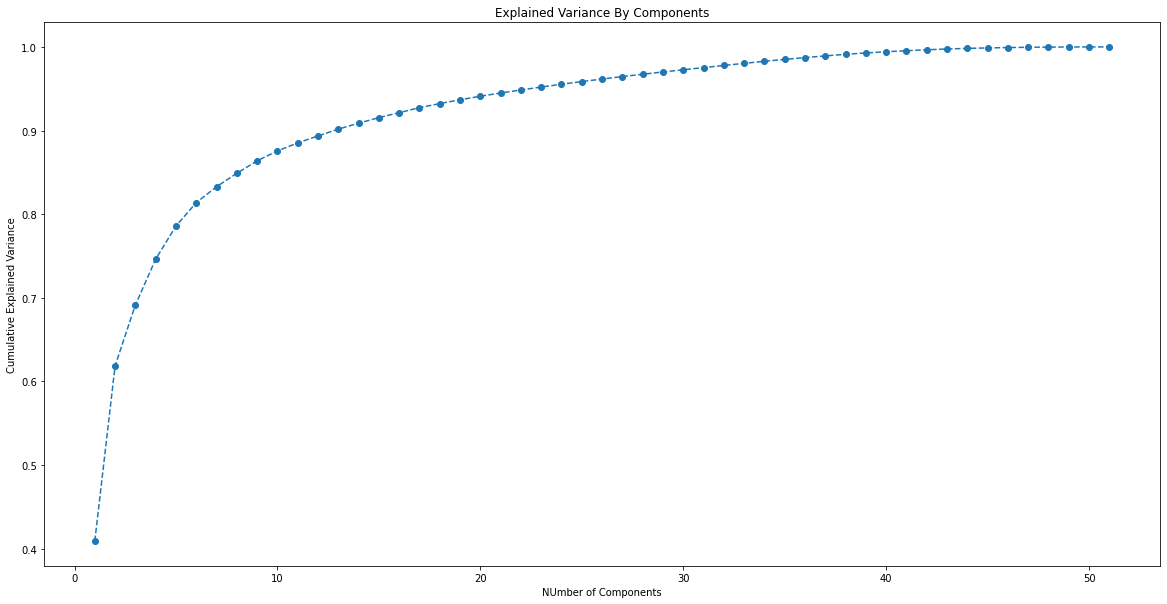

In [56]:
plt.figure(figsize=(20,10))
plt.plot(range(1,52),pca.explained_variance_ratio_.cumsum(),marker='o',linestyle='--')
plt.title('Explained Variance By Components')
plt.xlabel('NUmber of Components')
plt.ylabel('Cumulative Explained Variance')

In [57]:
pca=PCA(n_components=10)

In [58]:
pca.fit(X_norm)

PCA(n_components=10)

In [59]:
pca.transform(X_norm)

array([[-1.91863102, -1.02423751,  1.37417166, ...,  0.33240556,
         0.39512666,  0.2233272 ],
       [-1.77738549, -0.9754636 ,  1.32864864, ...,  0.3422105 ,
         0.37486316,  0.17113782],
       [-1.79594968, -1.19229286,  1.14974572, ...,  0.55374889,
         0.25880874,  0.32049491],
       ...,
       [ 2.30678233, -0.45190573,  0.13213165, ..., -0.08913041,
         0.05086865,  0.09127706],
       [ 0.57522605,  0.49020353, -0.58623577, ...,  0.24693987,
         0.11721261,  0.2659592 ],
       [-0.05734531, -0.13280632, -0.20323274, ...,  0.00542325,
         0.02561799,  0.21024631]])

In [60]:
scores_pca=pca.transform(X_norm)

In [61]:
scores_pcaedit=pd.DataFrame(scores_pca)
scores_pcaedit

0         1         2         3         4         5         6  \
0     -1.918631 -1.024238  1.374172 -0.346553 -0.198645 -0.090935 -0.453370   
1     -1.777385 -0.975464  1.328649  0.029689 -0.610358 -0.367171 -0.272082   
2     -1.795950 -1.192293  1.149746 -0.516651 -0.281737  0.059153 -0.410064   
3      1.513097 -0.367213  1.438623 -0.686902 -0.625154 -0.109969 -0.201941   
4     -1.705618 -1.031491  1.092787 -0.465729 -0.427968  0.058392 -0.082603   
...         ...       ...       ...       ...       ...       ...       ...   
14621  0.514709  0.445041 -0.526080 -0.117455  0.132726 -0.050623  0.315189   
14622  0.163199 -0.037200 -0.452761  0.147308  0.420604  0.017143 -0.019108   
14623  2.306782 -0.451906  0.132132  0.027091  0.505168 -0.050776  0.203444   
14624  0.575226  0.490204 -0.586236 -0.133991  0.100976 -0.044838  0.303764   
14625 -0.057345 -0.132806 -0.203233  0.030161  0.330375 -0.083127  0.135508   

              7         8         9  
0      0.332406  0.395127  0.223327  
1      0.342211  0.374863  0.171138  
2      0.553749  0.258809  0.320495  
3      0.301450  0.228385 -0.008731  
4      0.387298  0.378960  0.339880  
...         ...       ...       ...  
14621  0.247568  0.127022  0.307566  
14622  0.068300  0.050814  0.174297  
14623 -0.089130  0.050869  0.091277  
14624  0.246940  0.117213  0.265959  
14625  0.005423  0.025618  0.210246  

[14626 rows x 10 columns]

In [62]:
#Find the k(no of clusters) by  using Elbow method
#inertia = sum of squared distance of samples to their closet cluster center.It uses euclidian distance only
wcss=[] #within cluster sum of square
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++',max_iter= 300, n_init=10)
    kmeans.fit(scores_pca)
    wcss.append(kmeans.inertia_)
    
wcss    

[19616.330462941485,
 12785.325305422313,
 9026.332115287218,
 7206.639728017106,
 6435.755815652217,
 5876.036946812396,
 5501.927400963697,
 5221.762622294145,
 4971.801963499278,
 4824.071662850667]

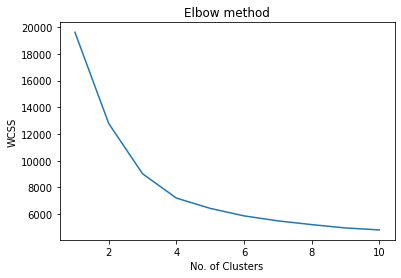

In [63]:
plt.plot(range(1,11),wcss)
plt.title("Elbow method")
plt.xlabel("No. of Clusters")
plt.ylabel("WCSS")
plt.show()

## Selecting the number of clusters with silhouette analysis on KMeans clustering

In [64]:
for i in range(2,11):
    labels=KMeans(n_clusters=i,init='k-means++').fit(scores_pca).labels_
    print('Silhouette Score for K (clusters)='+ str(i)+' is '+str(silhouette_score(scores_pca,labels,metric='euclidean',sample_size=1000)))
    

Silhouette Score for K (clusters)=2 is 0.509980189458352
Silhouette Score for K (clusters)=3 is 0.3089950560019288
Silhouette Score for K (clusters)=4 is 0.2883562504034555
Silhouette Score for K (clusters)=5 is 0.2614917789137347
Silhouette Score for K (clusters)=6 is 0.24823269407135584
Silhouette Score for K (clusters)=7 is 0.24142322804224328
Silhouette Score for K (clusters)=8 is 0.21567045420122088
Silhouette Score for K (clusters)=9 is 0.23077158317912774
Silhouette Score for K (clusters)=10 is 0.19254358402040053


For n_clusters = 2 The average silhouette_score is : 0.5030411395958592
For n_clusters = 3 The average silhouette_score is : 0.3178166703023399
For n_clusters = 4 The average silhouette_score is : 0.2954331574284774
For n_clusters = 5 The average silhouette_score is : 0.26576679468228365
For n_clusters = 6 The average silhouette_score is : 0.24978928442900328


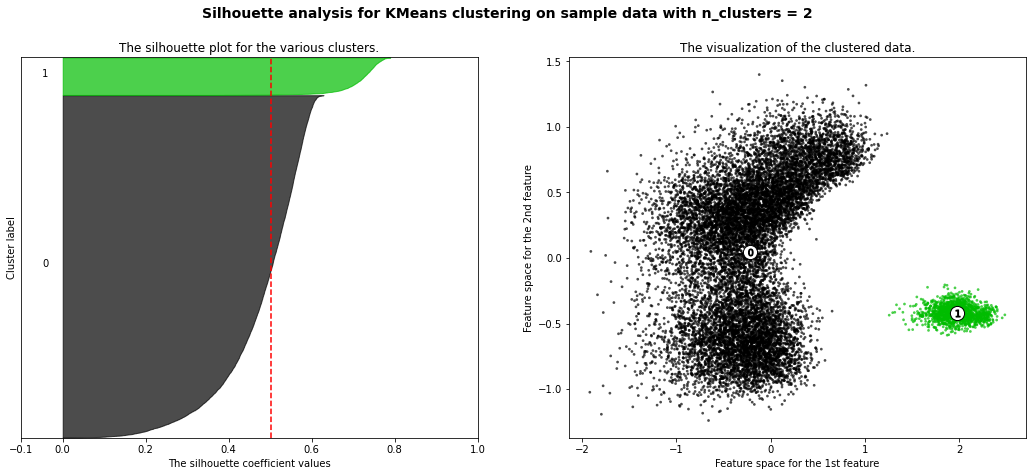

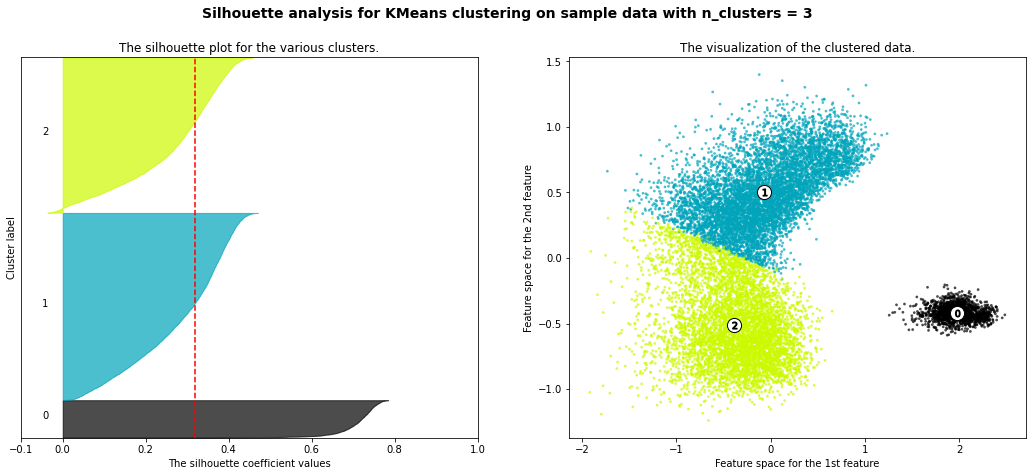

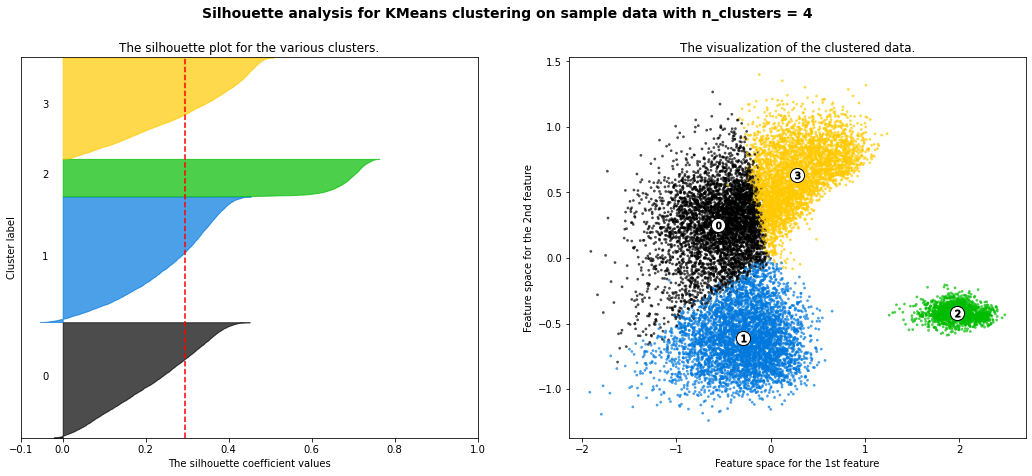

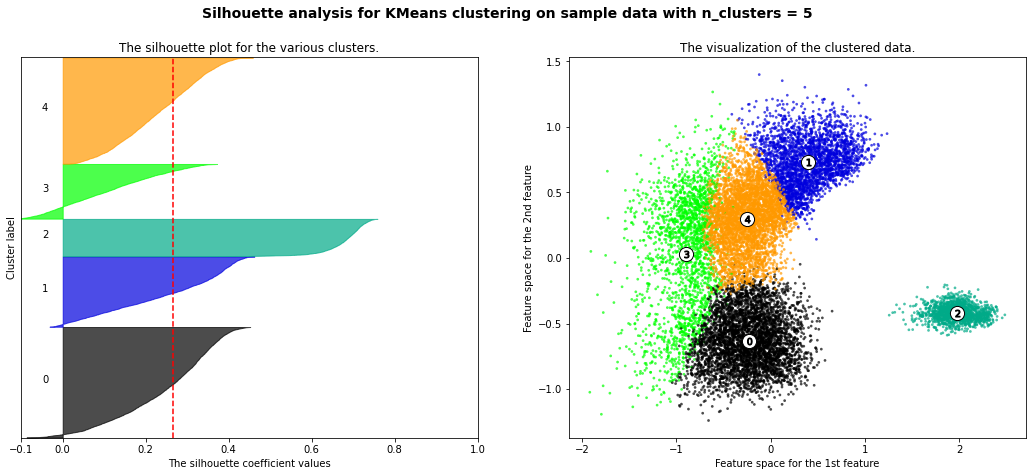

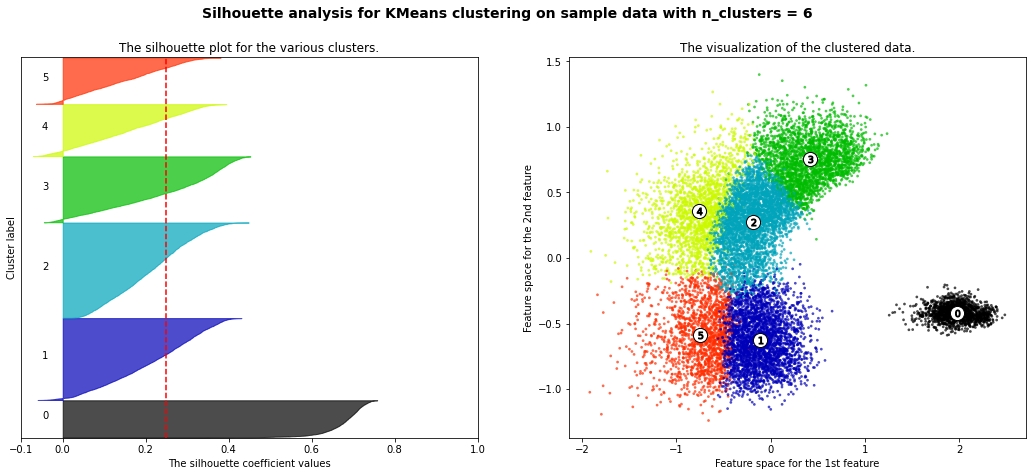

In [65]:
from sklearn.datasets import make_blobs

import matplotlib.cm as cm

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=4,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=1,
)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(scores_pca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(scores_pca)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(scores_pca, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(scores_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        scores_pca[:, 0], scores_pca[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

# Perform K-Means clustering 

In [66]:
# specify the number of clusters
kmeans_pca = KMeans(n_clusters=2,init='k-means++',random_state=42)

In [67]:
# fit the input data
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=2, random_state=42)

In [68]:
#K-means clustering with PCA Results
df_seg_pca_kmeans=pd.concat([data.reset_index(drop=True),pd.DataFrame(scores_pca)],axis=1)
df_seg_pca_kmeans.columns.values[-10:]=['Comp 1','Comp 2','Comp 3','Comp 4','Comp 5','Comp 6','Comp 7','Comp 8','Comp 9','Comp 10']
df_seg_pca_kmeans['name']=names
df_seg_pca_kmeans['Segment K-Means PCA']=kmeans_pca.labels_

In [69]:
df_seg_pca_kmeans.head()

age  overall  potential  value_eur  wage_eur  international_reputation  \
0   32       94         94   95500000    565000                  1.609438   
1   34       93         93   58500000    405000                  1.609438   
2   27       92         92  105500000    290000                  1.609438   
3   26       91         93   77500000    125000                  1.098612   
4   28       91         91   90000000    470000                  1.386294   

   weak_foot  skill_moves  release_clause_eur  contract_valid_until  ...  \
0          4            4           19.092604                2021.0  ...   
1          4            5           18.385054                2022.0  ...   
2          5            5           19.089535                2022.0  ...   
3          3            1           18.919636                2023.0  ...   
4          4            4           19.033160                2024.0  ...   

     Comp 3    Comp 4    Comp 5    Comp 6    Comp 7    Comp 8    Comp 9  \
0  1.374172 -0.346553 -0.198645 -0.090935 -0.453370  0.332406  0.395127   
1  1.328649  0.029689 -0.610358 -0.367171 -0.272082  0.342211  0.374863   
2  1.149746 -0.516651 -0.281737  0.059153 -0.410064  0.553749  0.258809   
3  1.438623 -0.686902 -0.625154 -0.109969 -0.201941  0.301450  0.228385   
4  1.092787 -0.465729 -0.427968  0.058392 -0.082603  0.387298  0.378960   

    Comp 10               name  Segment K-Means PCA  
0  0.223327           L. Messi                    1  
1  0.171138  Cristiano Ronaldo                    1  
2  0.320495          Neymar Jr                    1  
3 -0.008731           J. Oblak                    0  
4  0.339880          E. Hazard                    1  

[5 rows x 63 columns]

In [70]:
df_seg_pca_kmeans['Segment']=df_seg_pca_kmeans['Segment K-Means PCA'].map({0:'first',1:'second',2:'third'})

## For Component 1 and Component 2

In [71]:
x_axis=df_seg_pca_kmeans['Comp 1']
y_axis=df_seg_pca_kmeans['Comp 2']

/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


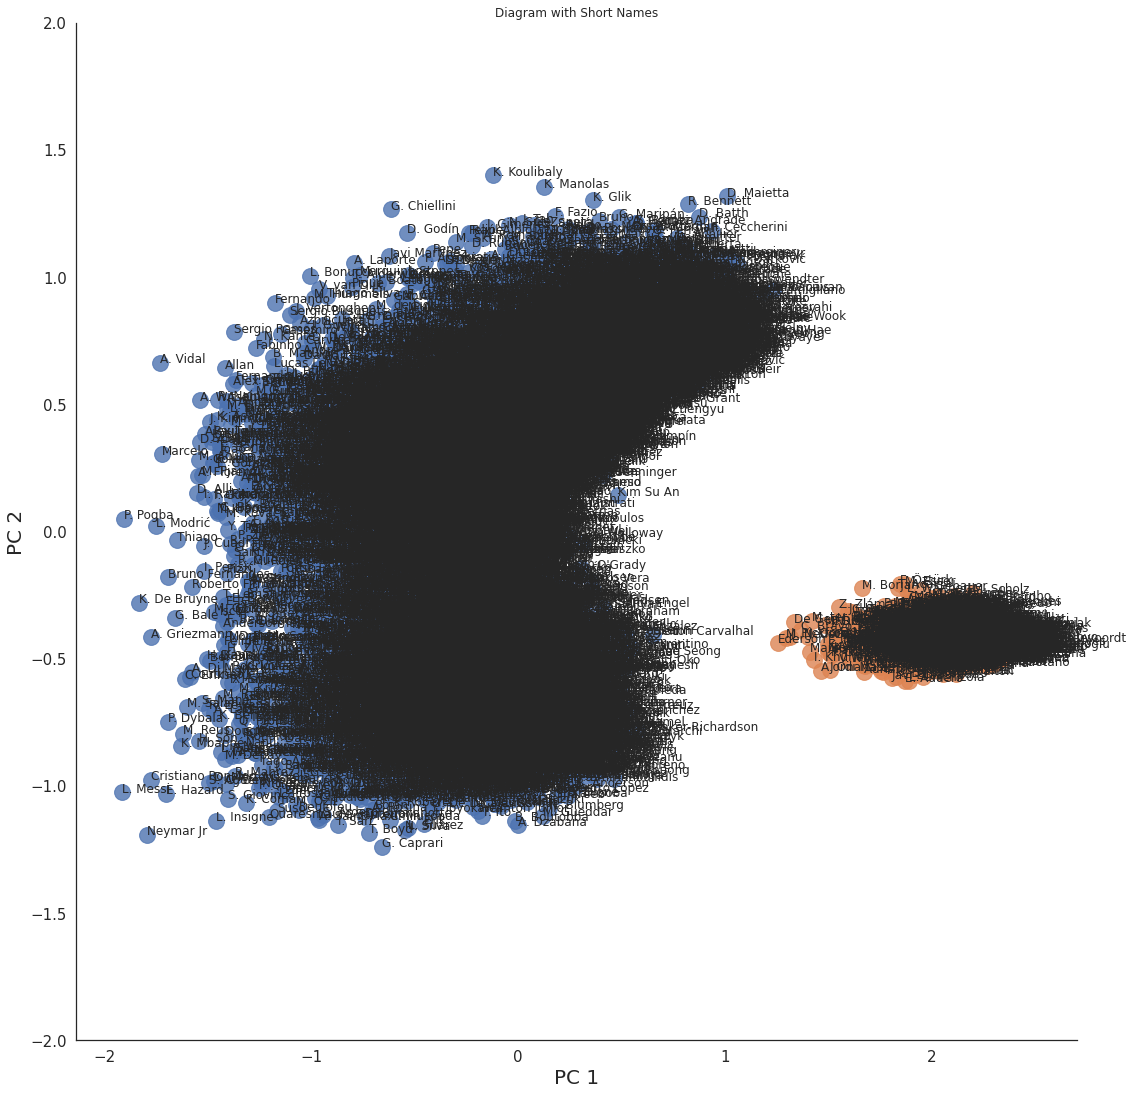

In [72]:
sns.set(style="white")

ax = sns.lmplot(x="Comp 1", y="Comp 2", hue='Segment', data = df_seg_pca_kmeans, legend=False,
                   fit_reg=False, size = 15, scatter_kws={"s": 250})

texts = []
for x, y, s in zip(x_axis, y_axis, df_seg_pca_kmeans.name):
    texts.append(plt.text(x, y, s))

ax.set(ylim=(-2, 2))
plt.tick_params(labelsize=15)
plt.xlabel("PC 1", fontsize = 20)
plt.ylabel("PC 2", fontsize = 20)
plt.title('Diagram with Short Names')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


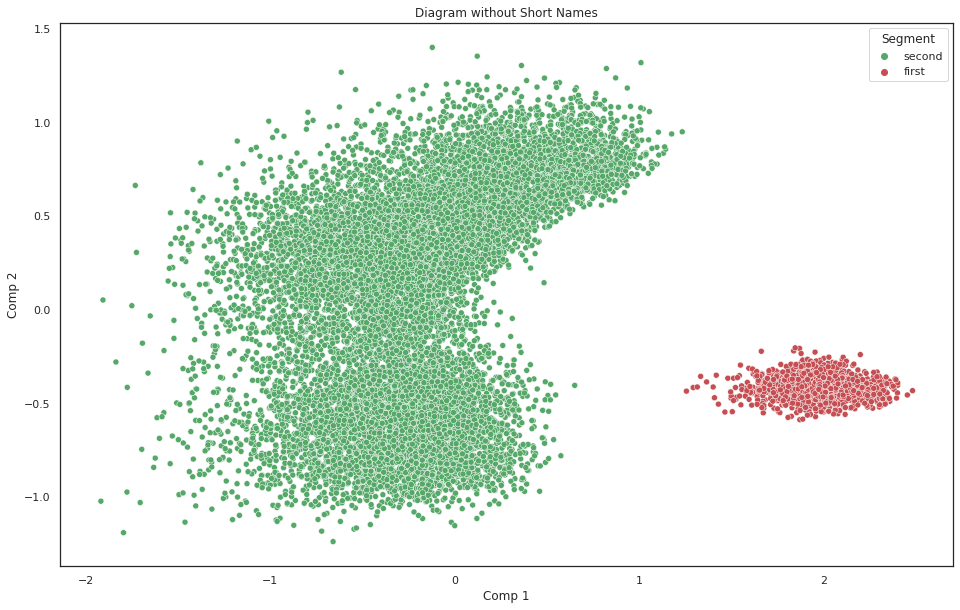

In [73]:
x_axis=df_seg_pca_kmeans['Comp 1']
y_axis=df_seg_pca_kmeans['Comp 2']
plt.figure(figsize=(16,10))
sns.scatterplot(x_axis,y_axis,hue=df_seg_pca_kmeans['Segment'],palette=['g','r'])
plt.title('Diagram without Short Names')
plt.show()

# Using DBSCAN When eps=1

In [74]:
from sklearn.cluster import DBSCAN

# train the model using DBSCAN
db = DBSCAN(eps=1, min_samples=5)

# prediction for dbscan clusters
db_clusters = db.fit_predict(scores_pca)

In [75]:
silhouette_score(x_scaled,db_clusters)

0.45639086311053767

In [76]:
df_seg_pca_kmeans['Cluster']=db_clusters

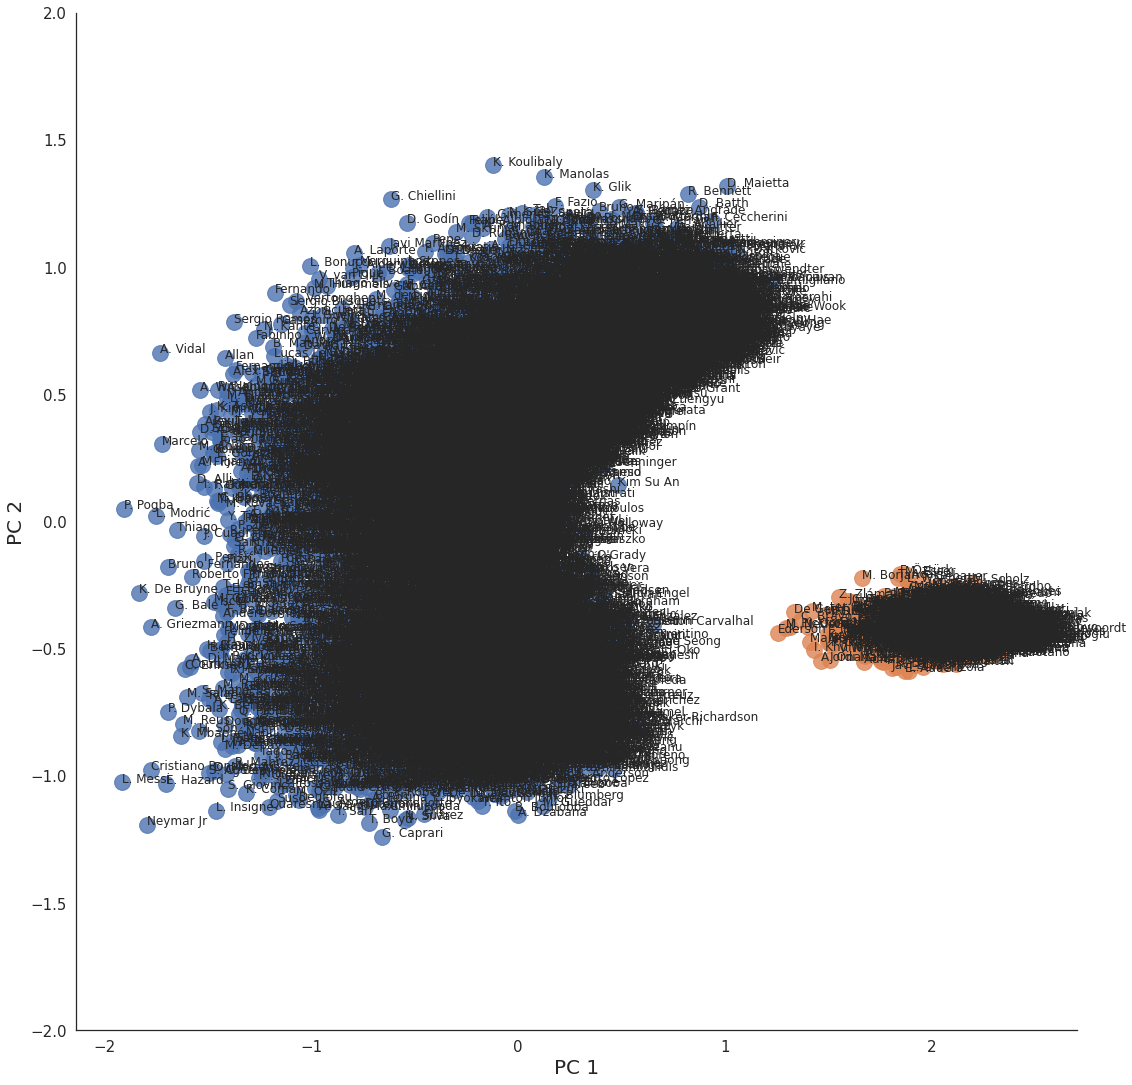

In [77]:
sns.set(style="white")

ax = sns.lmplot(x="Comp 1", y="Comp 2", hue='Cluster', data = df_seg_pca_kmeans, legend=False,
                   fit_reg=False, height = 15, scatter_kws={"s": 250})

texts = []
for x, y, s in zip(x_axis, y_axis, df_seg_pca_kmeans.name):
    texts.append(plt.text(x, y, s))

ax.set(ylim=(-2, 2))
plt.tick_params(labelsize=15)
plt.xlabel("PC 1", fontsize = 20)
plt.ylabel("PC 2", fontsize = 20)

plt.show()

### When Eps=0.7

In [78]:
from sklearn.cluster import DBSCAN

# train the model using DBSCAN
db = DBSCAN(eps=0.7, min_samples=5)

# prediction for dbscan clusters
db_clusters = db.fit_predict(scores_pca)

In [79]:
silhouette_score(x_scaled,db_clusters)

0.27430473969670366

In [80]:
df_seg_pca_kmeans['Cluster']=db_clusters

In [81]:
np.unique(db_clusters)

array([-1,  0,  1])

/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


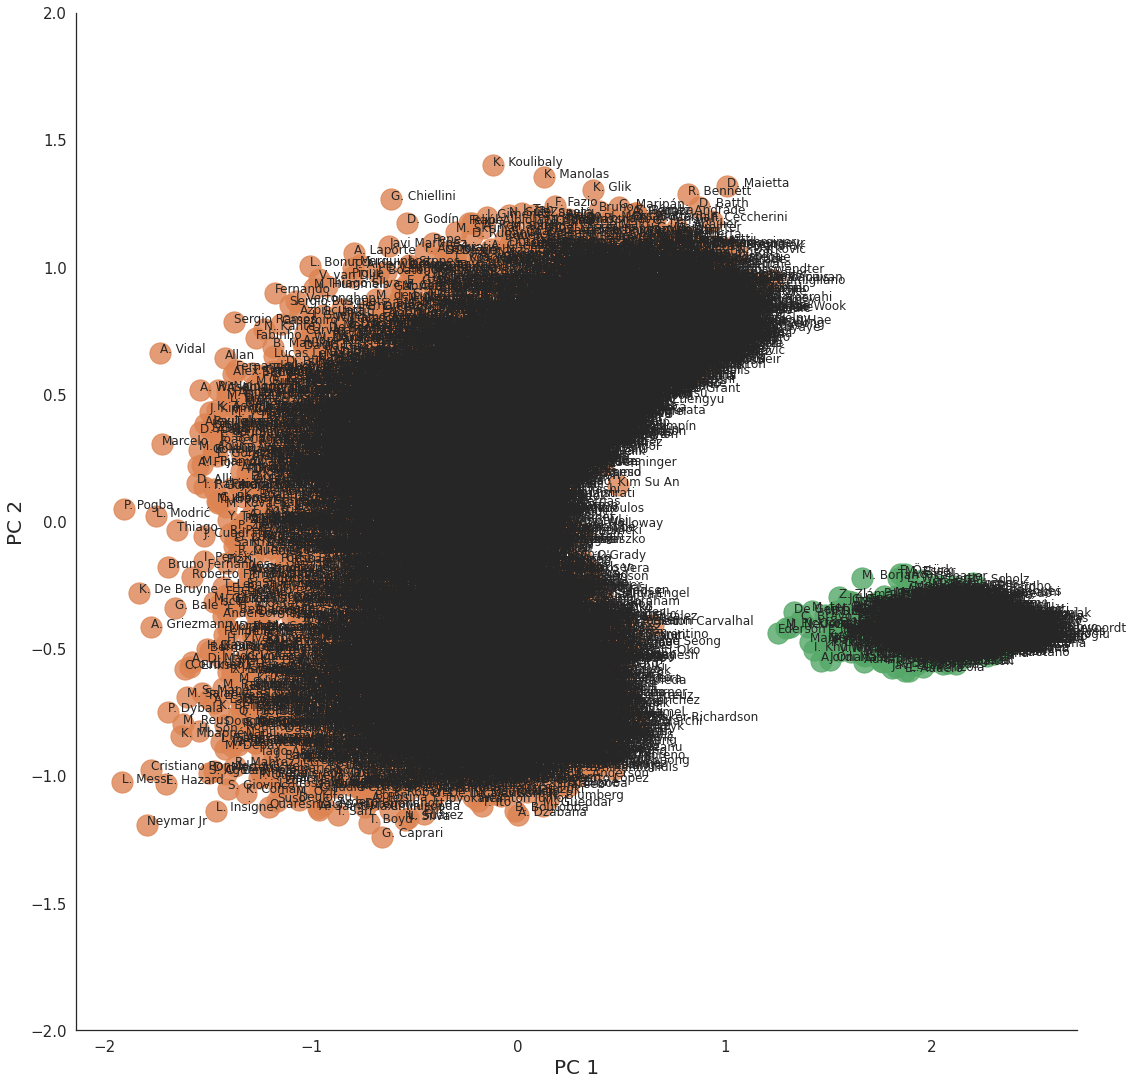

In [82]:
sns.set(style="white")

ax = sns.lmplot(x="Comp 1", y="Comp 2", hue='Cluster', data = df_seg_pca_kmeans, legend=False,
                   fit_reg=False, size = 15, scatter_kws={"s": 450})

texts = []
for x, y, s in zip(x_axis, y_axis, df_seg_pca_kmeans.name):
    texts.append(plt.text(x, y, s))

ax.set(ylim=(-2, 2))
plt.tick_params(labelsize=15)
plt.xlabel("PC 1", fontsize = 20)
plt.ylabel("PC 2", fontsize = 20)

plt.show()

# Hierarchical Clustering

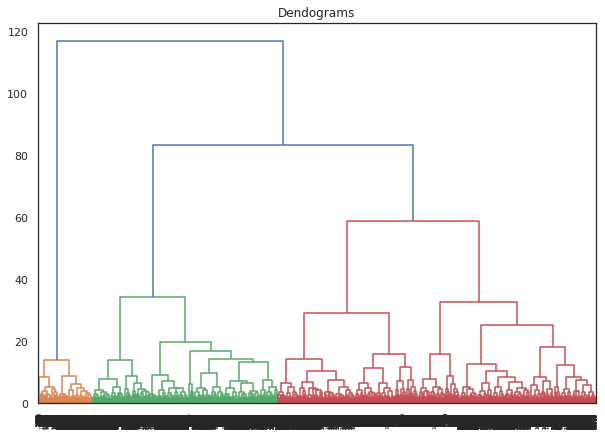

In [83]:
plt.figure(figsize=(10,7))
plt.title("Dendograms")
dend=shc.dendrogram(shc.linkage(x_scaled,method='ward'))#method ward is used to reducing the variance among the groups

### Check for Largest Distance Vertically without crossing any horizontal Line

In [84]:
cluster=AgglomerativeClustering(n_clusters=2,affinity="euclidean",linkage="ward")
cl=cluster.fit_predict(x_scaled)

In [85]:
silhouette_score(x_scaled,cl)

0.45639086311053767

In [86]:
cluster=AgglomerativeClustering(n_clusters=3,affinity="euclidean",linkage="ward")
cl=cluster.fit_predict(x_scaled)

In [87]:
silhouette_score(x_scaled,cl)

0.24316475521930273

## Among 3 algorithms, K-means has given better silhouette_score i.e 0.50. with cluster =2 